In [1]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.layers.normalization import BatchNormalization
from assets.keras.keras.optimizers import SGD, RMSprop, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
from assets.keras.keras.callbacks import EarlyStopping
import theano
import matplotlib.pyplot as plt
import math
from assets.vis_utils import *
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

Using Theano backend.
/root/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")
Using Theano backend.


In [19]:
from assets.gen_motion import gen_dataset
import math

angles = [0,math.pi/4,math.pi/2,math.pi*3/4,math.pi,math.pi*5/4,math.pi*3/2,math.pi*7/4]
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,64,64),150,None,['translate'],[3],angles,[1],[10],[15],dot_radius=2,contrast=1,Snoise=1,retina=0)

Y_train[:,2] = Y_train[:,2]/math.pi*4
Y_val[:,2] = Y_val[:,2]/math.pi*4
Y_test[:,2] = Y_test[:,2]/math.pi*4

##### WARNING ##########################################
# CHANGE THIS CODE IF YOU CHANGE THE NUMBER OF CLASSES #
######################################## WARNING #######
nb_classes = len(angles)
Y_train = np_utils.to_categorical(Y_train[:,2]-1, nb_classes)
Y_val = np_utils.to_categorical(Y_val[:,2]-1,nb_classes)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, nb_classes)



In [15]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (800, 1, 16, 64, 64))
('Y_train shape:', (800, 8))
('X_val shape:', (80, 1, 16, 64, 64))
('Y_val shape:', (80, 8))
('X_test shape:', (80, 1, 16, 64, 64))
('Y_test shape:', (80, 8))
(800, 'train samples')
(80, 'val samples')
(80, 'test samples')


<IPython.core.display.Javascript object>


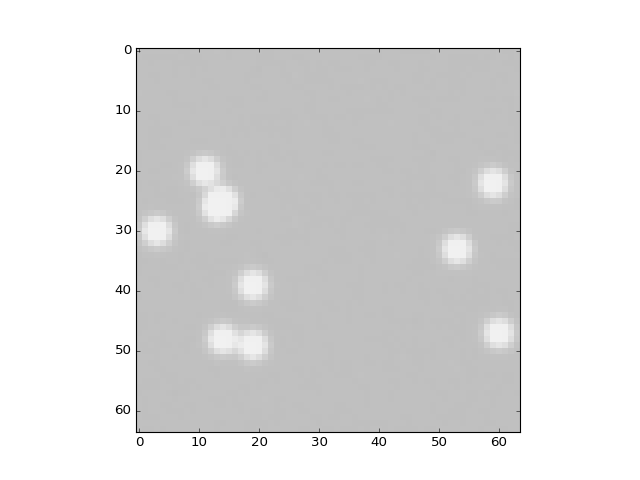

In [11]:
visualize_matrix(X_train[10,0,:,:,:],interval_len=50,ubound=255)

In [26]:
def build_eval(params,r,l,nb_f,nb_p,nb_c,data,model):
    batch_size, nb_classes, nb_epoch = params
    X_train,Y_train,X_val,Y_val,X_test,Y_test = data
    if model==None:
        model = Sequential()
        model.add(ZeroPadding3D((0,1,1),input_shape=(1,16,64,64), dim_ordering='th',))
        model.add(Convolution3D(nb_f[0],len_conv_dim1=1, len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                                 activation='relu', W_regularizer=l2(r),name='LGN'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, nb_p[0], nb_p[0])))
        #model.add(Dropout(0.5))
        model.add(ZeroPadding3D((0,1,1)))
        model.add(Convolution3D(nb_f[1],len_conv_dim1=1, len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='V1s'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
        #model.add(Dropout(0.5))
        model.add(ZeroPadding3D((0,1,1)))
        model.add(Convolution3D(nb_f[2],len_conv_dim1=1, len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='V1c'))
        model.add(BatchNormalization())
        model.add(Convolution3D(nb_f[2],len_conv_dim1=5, len_conv_dim2=nb_c[3], len_conv_dim3=nb_c[3], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='MT'))
        model.add(Flatten())
        #model.add(Dropout(0.5))
        #model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
        model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
        model.add(Activation('softmax'))

        #Adam
        sgd = RMSprop(lr=l, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, class_mode='categorical')

        
    # control the model to crash early if nothing happens
    earlyStopping=EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
              validation_data=(X_val,Y_val), callbacks=[earlyStopping])
    scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
    scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
    return (model, hist, scoretr, scoreva)

In [27]:
iters = 1

data = (X_train,Y_train,X_val,Y_val,X_test,Y_test)

best_model = None
best_val = 0
best_hist = None
best_scoretr = None
best_scoreva = None
best_params = None


batch_size = 40
nb_epoch = 10

params = (batch_size,nb_classes,nb_epoch)

for i in range(iters):
    # for each iteration
    print 'Training model #: ', i+1
    nb_filters = [4,4,4] #[2**np.random.randint(2,3),2**np.random.randint(2,3),2**np.random.randint(2,3)]
    nb_pool = [2,2]
    nb_conv = [3,3,3,3]
    reg = 1e-3#10**(-1*np.random.rand()*2)
    l_r = 2e-3#10**(-1*(np.random.rand()*2+4))
    model,hist,scoretr,scoreva = build_eval(params,reg,l_r,nb_filters,nb_pool,nb_conv,data,None)
    if scoreva[1] > best_val:
        best_model = model
        best_hist = hist
        best_scoretr = scoretr
        best_scoreva = scoreva
        best_val = scoreva[1]
        best_params = (reg,l_r,nb_filters,nb_pool,nb_conv)
    

Training model #:  1
Train on 1200 samples, validate on 120 samples
Epoch 1/10
1200/1200 [==============================] - 70s - loss: 2.1642 - acc: 0.1175 - val_loss: 2.0795 - val_acc: 0.1250
Epoch 2/10
1200/1200 [==============================] - 68s - loss: 2.1254 - acc: 0.1792 - val_loss: 2.0052 - val_acc: 0.3083
Epoch 3/10
1200/1200 [==============================] - 68s - loss: 1.8103 - acc: 0.4350 - val_loss: 1.4572 - val_acc: 0.5083
Epoch 4/10
1200/1200 [==============================] - 68s - loss: 1.0895 - acc: 0.7117 - val_loss: 1.0179 - val_acc: 0.6167
Epoch 5/10
1200/1200 [==============================] - 68s - loss: 0.5431 - acc: 0.8975 - val_loss: 0.5400 - val_acc: 0.7667
Epoch 6/10
1200/1200 [==============================] - 68s - loss: 0.2814 - acc: 0.9642 - val_loss: 0.3428 - val_acc: 0.8583
Epoch 7/10
1200/1200 [==============================] - 68s - loss: 0.1634 - acc: 0.9933 - val_loss: 0.2086 - val_acc: 0.9333
Epoch 8/10
1200/1200 [============================

In [28]:
scorete = best_model.evaluate(X_test, Y_test, batch_size=20, show_accuracy=True)
print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
print('Val loss:', best_scoreva[0])
print('Val accuracy:', best_scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])
print best_params

120/120 [==============================] - 1s     
('Train loss:', 0.004448858336157476)
('Train accuracy:', 1.0)
('Val loss:', 0.13166029006242752)
('Val accuracy:', 0.96666666666666667)
('Test loss:', 0.13044358727832636)
('Test accuracy:', 0.94166666666666665)
(0.001, 0.002, [4, 4, 4], [2, 2], [3, 3, 3, 3])


In [31]:
#save model in motnet/assets/model folder
from assets.saveloadmodel import savemodel
from assets.saveloadmodel import loadmodel

#set model unique id and save model
#this saves two files one called "mymodel1.json" (net architecture)
#and another file "mymodelweights1.h5" (net weights)
#change modelid to update the saved filename (e.g., modelid = 2
#saves "mymodel2" and "mymodelweights2.h5")
modelid = 300
savemodel(best_model,modelid)

#load saved model and evaluate for sanity check
thismodel = loadmodel(modelid)

done
0.0206990242004 sec


<IPython.core.display.Javascript object>


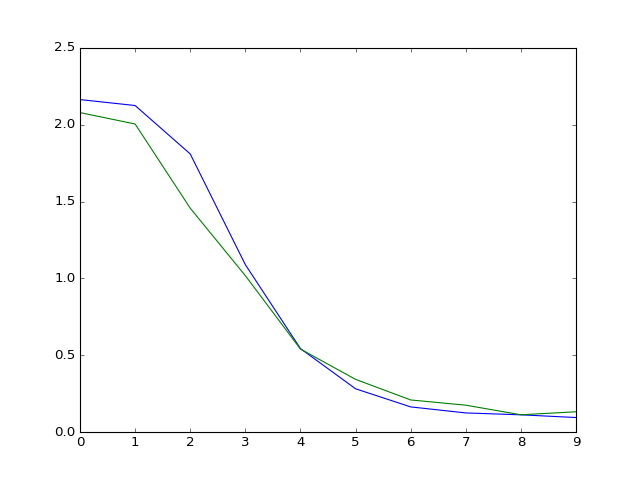

In [33]:
#print best_model.history.history.keys()
plt.plot(np.asarray(best_model.history.history['loss'])[0:500])
plt.plot(np.asarray(best_model.history.history['val_loss'])[0:500])
# cannot draw history for thismodel--history does not get svaed

In [ ]:
##### NOT USEFUL FOR 3x3 CONVS #######

# (#outputs,#inputs,time,x-dir,y-dir)
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    # visualize the feature weights in the first 3 layers
    if layer.name in ['LGN','V1s','V1c','MT']:
        W,b = layer.get_weights()
        visualize_grid(W)

In [36]:
from assets.validation import *

In [ ]:
reps = 5
coh_data = validate_model(best_model,reps,(1,1,150))

In [99]:
from assets.vis_utils import *

In [113]:
out = feature_inversion(best_model,['LGN','V1','MT'])

Running layer:  LGN
Running layer:  V1
Running layer:  MT


<IPython.core.display.Javascript object>


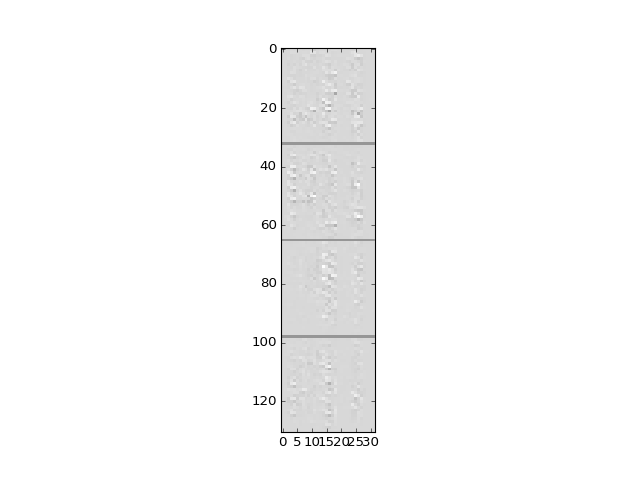

In [123]:
visualize_grid(np.expand_dims(out[2],axis=1),ubound=255)

<IPython.core.display.Javascript object>


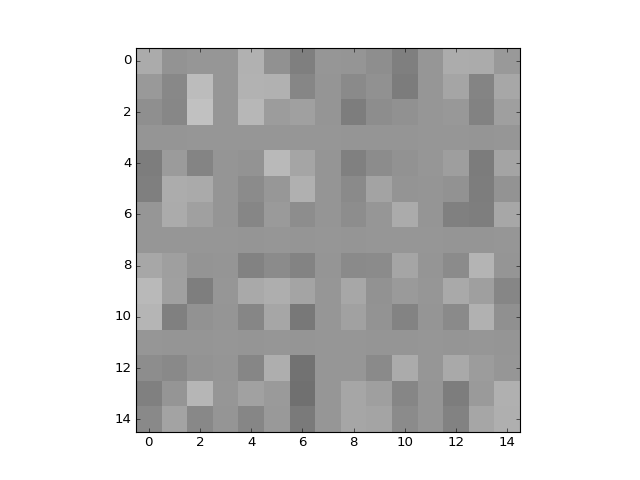

In [127]:
best_model.layers[8].name

'MT'